In [1]:
!conda info


     active environment : base
    active env location : /Users/l1x/miniconda3
            shell level : 1
       user config file : /Users/l1x/.condarc
 populated config files : 
          conda version : 4.7.10
    conda-build version : not installed
         python version : 3.7.3.final.0
       virtual packages : 
       base environment : /Users/l1x/miniconda3  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/osx-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/osx-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /Users/l1x/miniconda3/pkgs
                          /Users/l1x/.conda/pkgs
       envs directories : /Users/l1x/miniconda3/envs
                          /Users/l1x/.conda/envs
               platform : osx-64
             user-agent : conda/4.7.10 requests/2.22.0 CPython/3.7.3 Darwin/18.7.0 OSX/10.14.6
                U

In [1]:
import datetime as dt
import hashlib
import pprint
import re
import os

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns

from botocore.exceptions import ClientError
from pyhive import presto
from scipy import stats

(pd.__version__,sns.__version__, np.__version__)

('0.25.1', '0.9.0', '1.17.0')

In [3]:
pp = pprint.PrettyPrinter(indent=2)

### Generating some example data

In [4]:
def date_range(start_date=dt.date(2019, 9, 1), end_date = dt.date(2019, 9, 30)):
    delta = end_date - start_date
    dates = [start_date + dt.timedelta(days=i) for i in range(delta.days + 1)]
    return [str(d) for d in dates]

In [5]:
def gen_data(sample_size=10_000_000):
    f0 = np.random.randint(2, size=sample_size)
    aa_milne_arr = ['pooh', 'rabbit', 'piglet', 'christopher']
    f1 = np.random.choice(aa_milne_arr, size=sample_size, p=[0.5, 0.1, 0.1, 0.3])
    f2 = np.random.randint(5_000, size=sample_size)
    ds_arr = date_range()
    f3 = np.random.choice(ds_arr, size=sample_size)
    dl = ['2019-08-23 16:24:55.000', '2019-08-23 15:51:07.000',
           '2019-08-23 15:41:30.000', '2019-08-23 15:36:45.000',
           '2019-08-06 13:54:36.000', '2019-08-02 11:32:04.000',
           '2019-08-23 11:15:20.000', '2019-08-23 11:07:46.000',
           '2019-08-12 10:51:20.000', '2019-08-23 10:51:19.000',
           '2019-08-29 10:33:24.000', '2019-08-23 09:50:18.000',
           '2019-08-23 08:21:51.000', '2019-08-11 11:50:55.000',
           '2019-08-22 11:36:52.000', '2019-08-22 11:31:24.000',
           '2019-08-22 09:56:18.000', '2019-08-21 21:42:50.000',
           '2019-08-21 21:11:08.000', '2019-08-15 21:09:18.000',
           '2019-08-17 21:04:52.000', '2019-08-21 20:57:57.000',
           '2019-08-21 20:27:09.000', '2019-08-21 20:06:50.000',
           '2019-08-12 20:01:00.000', '2019-08-07 19:50:41.000',
           '2019-08-21 17:53:00.000', '2019-08-21 17:38:45.000',
           '2019-08-01 16:37:32.000', '2019-08-15 14:04:18.000',
           '2019-08-15 13:42:21.000', '2019-08-15 13:36:25.000',
           '2019-08-15 13:27:50.000', '2019-08-20 13:22:55.000']
    dd = [np.datetime64(d) for d in dl]
    f4 = np.random.choice(dd, size=sample_size)
    f5 = np.random.randint(500_000, size=sample_size)
    sha_arr = [hashlib.sha224(bytes(s, 'UTF8')).hexdigest() for s in ds_arr]
    f6 = np.random.choice(sha_arr, size=sample_size)
    cities_arr = [
        'Seattle',
        'Los Angeles',
        'Portland',
        'San Diego',
        'Phoenix',
        'Dallas',
        'Houston',
        'Charlotte',
        'Detroit',
        'Nashville'
    ]
    f7 = np.random.choice(cities_arr, size=sample_size)
    f8 = np.random.random_sample((sample_size,))
    return (f0, f1, f2, f3, f4, f5, f6, f7, f8)

In [6]:
data = gen_data(sample_size=100)
df = pd.DataFrame({
    'bin_int': data[0], 'milne': data[1], 'rint_5_000': data[2],
    'ds': data[3], 'rdates': data[4], 'rint_500_000': data[5],
    'sha': data[6], 'cities': data[7], 'rfloat': data[8],
})
df.head()

,bin_int,milne,rint_5_000,ds,rdates,rint_500_000,sha,cities,rfloat
0,0,pooh,1751,2019-09-08,2019-08-23 09:50:18,13108,3af32c12feff47cc425ee8e988b5a98f938b08571759d0...,Detroit,0.522637
1,0,christopher,4785,2019-09-23,2019-08-15 13:36:25,380253,f6619dacd12b6d33a3b8cfd1f5b87ed9d7da115e5abde6...,Dallas,0.982727
2,1,pooh,3742,2019-09-23,2019-08-07 19:50:41,47623,f42da457f4d31d2ebba7c9743f40c75188a468235a2db2...,Nashville,0.484912
3,1,pooh,1368,2019-09-03,2019-08-21 17:38:45,242048,38ae948be43dd5bfdd0f5ab70646fcfd59c540f3405637...,Nashville,0.370233
4,1,christopher,4956,2019-09-13,2019-08-15 13:36:25,419511,e5dbf8b6cc9aec3c04c30daa03d5d04394f5a87700d77b...,Houston,0.566193


In [7]:
#df_sample = df.sample(10)

In [8]:
if True == False:
    for i in range(20):
        data = gen_data(10_000_000)
        df = pd.DataFrame({
            'bin_int': data[0], 'milne': data[1],  'rint_5_000': data[2],
            'ds': data[3],      'rdates': data[4], 'rint_500_000': data[5],
            'sha': data[6],     'cities': data[7], 'rfloat': data[8],
        })
        file_name = "data_{0}.csv".format(i)
        df.to_csv(file_name, index=False, encoding='utf-8', header=False)

In [9]:
#if you ever store credentials in code you are doing it wrong
#either use instance profile to run inside AWS or use credential profile with local credential files
aws_region = 'eu-west-1'
aws_profile = 'li-istvan'
aws_credentials_file = '{0}/{1}'.format(os.environ['HOME'], '.aws/credentials')

if os.access(aws_credentials_file, os.R_OK):
    session = boto3.session.Session(profile_name=aws_profile, region_name=aws_region)
else:
    session = boto3.session.Session(region_name=aws_region)

s3_client = session.client('s3', )
s3_resource = session.resource('s3')

In [10]:
aws_s3_bucket = 'li-perf-test'
try:
    s3_client.create_bucket(Bucket=aws_s3_bucket, CreateBucketConfiguration={'LocationConstraint': aws_region})
except ClientError as e:
    if 'BucketAlreadyOwnedByYou' not in str(e):
        raise
    else:
        print("AWS S3 Bucket Already Created: ", aws_s3_bucket)

AWS S3 Bucket Already Created:  li-perf-test


In [11]:
[bucket.name for bucket in s3_resource.buckets.all() if re.match('.*perf.*', bucket.name) is not None]

['li-perf-test']

In [50]:
aws_s3_root_path='data'
def upload_file_to_aws_s3(file_name):
    aws_s3_object_name = '{aws_s3_root_path}/raw/{file_name}'.format(
        aws_s3_root_path=aws_s3_root_path, 
        file_name=file_name
    )
    try:
        s3_resource.Object(aws_s3_bucket, aws_s3_object_name).load()
    except ClientError as e:
        if e.response['Error']['Code'] == "404":
            pp.pprint('Uploading starting: {0}'.format(aws_s3_object_name))
            s3_client.upload_file(file_name, aws_s3_bucket, aws_s3_object_name)
            pp.pprint('Uploading finished...{0}'.format(aws_s3_object_name))
        else:
            raise
    else:
        pp.pprint('File has been uploaded previously: {0}'.format(aws_s3_object_name))
        
    return 'ok'

In [13]:
from multiprocessing import Pool
pool = Pool(5)
pool.map(upload_file_to_aws_s3, [x for x in os.listdir(".") if x.endswith(".csv")])

'File has been uploaded previously: data/raw/data_19.csv'
'File has been uploaded previously: data/raw/data_1.csv'
'File has been uploaded previously: data/raw/data_3.csv'
'File has been uploaded previously: data/raw/data_2.csv'
'File has been uploaded previously: data/raw/data_18.csv'
'File has been uploaded previously: data/raw/data_0.csv'
'File has been uploaded previously: data/raw/data_4.csv'
'File has been uploaded previously: data/raw/data_5.csv'
'File has been uploaded previously: data/raw/data_6.csv'
'File has been uploaded previously: data/raw/data_7.csv'
'File has been uploaded previously: data/raw/data_13.csv'
'File has been uploaded previously: data/raw/data_12.csv'
'File has been uploaded previously: data/raw/data_10.csv'
'File has been uploaded previously: data/raw/data_8.csv'
'File has been uploaded previously: data/raw/data_11.csv'
'File has been uploaded previously: data/raw/data_9.csv'
'File has been uploaded previously: data/raw/data_15.csv'
'File has been uploaded 

['ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok',
 'ok']

In [14]:
def list_objectin_aws_s3(aws_s3_bucket, aws_s3_object_prefix):
    paginator = s3_client.get_paginator('list_objects')
    filters = { 'Bucket': aws_s3_bucket,
                'Prefix': aws_s3_object_prefix }
    page_iterator = paginator.paginate(**filters)
    return [p['Key'] for page in page_iterator for p in page['Contents']]

In [51]:
list_objectin_aws_s3(aws_s3_bucket, 'data/raw')

['data/raw/data_0.csv',
 'data/raw/data_1.csv',
 'data/raw/data_10.csv',
 'data/raw/data_11.csv',
 'data/raw/data_12.csv',
 'data/raw/data_13.csv',
 'data/raw/data_14.csv',
 'data/raw/data_15.csv',
 'data/raw/data_16.csv',
 'data/raw/data_17.csv',
 'data/raw/data_18.csv',
 'data/raw/data_19.csv',
 'data/raw/data_2.csv',
 'data/raw/data_3.csv',
 'data/raw/data_4.csv',
 'data/raw/data_5.csv',
 'data/raw/data_6.csv',
 'data/raw/data_7.csv',
 'data/raw/data_8.csv',
 'data/raw/data_9.csv']

In [16]:
df.columns

Index(['bin_int', 'milne', 'rint_5_000', 'ds', 'rdates', 'rint_500_000', 'sha',
       'cities', 'rfloat'],
      dtype='object')

In [17]:
'''
CREATE DATABASE IF NOT EXISTS `perf`;
'''

'\nCREATE DATABASE IF NOT EXISTS `perf`;\n'

In [18]:
print('''CREATE EXTERNAL TABLE `perf`.`csv_test0`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT
   , `ds` STRING
   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
) 
ROW FORMAT DELIMITED 
FIELDS TERMINATED BY ',' 
LINES TERMINATED BY '\\n' 
STORED AS TEXTFILE 
LOCATION 's3://{aws_s3_bucket}/{aws_s3_root_path}/raw/';
'''.format(aws_s3_bucket=aws_s3_bucket, aws_s3_root_path=aws_s3_root_path))

CREATE EXTERNAL TABLE `perf`.`csv_test0`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT
   , `ds` STRING
   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
) 
ROW FORMAT DELIMITED 
FIELDS TERMINATED BY ',' 
LINES TERMINATED BY '\n' 
STORED AS TEXTFILE 
LOCATION 's3://li-perf-test/data/raw/';



In [19]:
print('''CREATE EXTERNAL TABLE `perf`.`orc_test1`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT
   , `ds` STRING
   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.orc.OrcSerde'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcOutputFormat'
LOCATION 's3://{aws_s3_bucket}/{aws_s3_root_path}/orc_test1/'
TBLPROPERTIES (
  'orc.compress'='ZLIB'
  );
'''.format(aws_s3_bucket=aws_s3_bucket, aws_s3_root_path=aws_s3_root_path))

CREATE EXTERNAL TABLE `perf`.`orc_test1`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT
   , `ds` STRING
   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.orc.OrcSerde'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcOutputFormat'
LOCATION 's3://li-perf-test/data/orc_test1/'
TBLPROPERTIES (
  'orc.compress'='ZLIB'
  );



In [20]:
print('''CREATE EXTERNAL TABLE `perf`.`orc_test0`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT
   , `ds` STRING
   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.orc.OrcSerde'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcOutputFormat'
LOCATION 's3://{aws_s3_bucket}/{aws_s3_root_path}/orc_test0/'
TBLPROPERTIES (
  'orc.compress'='SNAPPY'
  );
'''.format(aws_s3_bucket=aws_s3_bucket, aws_s3_root_path=aws_s3_root_path))

CREATE EXTERNAL TABLE `perf`.`orc_test0`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT
   , `ds` STRING
   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.orc.OrcSerde'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcOutputFormat'
LOCATION 's3://li-perf-test/data/orc_test0/'
TBLPROPERTIES (
  'orc.compress'='SNAPPY'
  );



In [21]:
'''INSERT INTO `perf`.`orc_test1` SELECT * FROM `perf`.`orc_test0`;'''

'INSERT INTO `perf`.`orc_test1` SELECT * FROM `perf`.`orc_test0`;'

In [22]:
print('''CREATE EXTERNAL TABLE `perf`.`orc_test2`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT

   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
PARTITIONED BY (
  `ds` string
)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.orc.OrcSerde'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcOutputFormat'
LOCATION 's3://{aws_s3_bucket}/{aws_s3_root_path}/orc_test2/'
TBLPROPERTIES (
  'orc.compress'='ZLIB',
  'orc.create.index'='true',
  'orc.stripe.size'='130023424',
  'orc.row.index.stride'='64000',
  'orc.create.index'='true'
)
;
'''.format(aws_s3_bucket=aws_s3_bucket, aws_s3_root_path=aws_s3_root_path))

CREATE EXTERNAL TABLE `perf`.`orc_test2`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT

   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
PARTITIONED BY (
  `ds` string
)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.orc.OrcSerde'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcOutputFormat'
LOCATION 's3://li-perf-test/data/orc_test2/'
TBLPROPERTIES (
  'orc.compress'='ZLIB',
  'orc.create.index'='true',
  'orc.stripe.size'='130023424',
  'orc.row.index.stride'='64000',
  'orc.create.index'='true'
)
;



In [23]:
print("""set hive.exec.dynamic.partition=true;
set hive.exec.dynamic.partition.mode=nonstrict;
INSERT OVERWRITE TABLE orc_test2 PARTITION (ds) 
SELECT bin_int, milne, rint_5_000, rdates, rint_500_000, sha, cities, rfloat, ds 
FROM orc_test1;""")

set hive.exec.dynamic.partition=true;
set hive.exec.dynamic.partition.mode=nonstrict;
INSERT OVERWRITE TABLE orc_test2 PARTITION (ds) 
SELECT bin_int, milne, rint_5_000, rdates, rint_500_000, sha, cities, rfloat, ds 
FROM orc_test1;


In [24]:
print('''CREATE EXTERNAL TABLE `perf`.`orc_test3`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT

   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
PARTITIONED BY (
  `ds` string
)
CLUSTERED BY (
  `sha`
)
INTO 8 BUCKETS
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.orc.OrcSerde'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcOutputFormat'
LOCATION 's3://{aws_s3_bucket}/{aws_s3_root_path}/orc_test3/'
TBLPROPERTIES (
  'orc.compress'='ZLIB',
  'orc.create.index'='true',
  'orc.stripe.size'='130023424',
  'orc.row.index.stride'='64000',
  'orc.create.index'='true'
)
;
'''.format(aws_s3_bucket=aws_s3_bucket, aws_s3_root_path=aws_s3_root_path))

CREATE EXTERNAL TABLE `perf`.`orc_test3`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT

   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
PARTITIONED BY (
  `ds` string
)
CLUSTERED BY (
  `sha`
)
INTO 8 BUCKETS
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.orc.OrcSerde'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcOutputFormat'
LOCATION 's3://li-perf-test/data/orc_test3/'
TBLPROPERTIES (
  'orc.compress'='ZLIB',
  'orc.create.index'='true',
  'orc.stripe.size'='130023424',
  'orc.row.index.stride'='64000',
  'orc.create.index'='true'
)
;



In [25]:
print("""set hive.exec.dynamic.partition=true;
set hive.exec.dynamic.partition.mode=nonstrict;
INSERT OVERWRITE TABLE `orc_test3` PARTITION(ds) 
SELECT `bin_int`, `milne`, `rint_5_000`, `rdates`, `rint_500_000`, `sha`, `cities`, `rfloat`, `ds` 
FROM orc_test2
ORDER BY cities, milne;""")

set hive.exec.dynamic.partition=true;
set hive.exec.dynamic.partition.mode=nonstrict;
INSERT OVERWRITE TABLE `orc_test3` PARTITION(ds) 
SELECT `bin_int`, `milne`, `rint_5_000`, `rdates`, `rint_500_000`, `sha`, `cities`, `rfloat`, `ds` 
FROM orc_test2
ORDER BY cities, milne;


In [26]:
print('''CREATE EXTERNAL TABLE `perf`.`orc_test4`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT

   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
PARTITIONED BY (
  `ds` string
)
CLUSTERED BY (
  `milne`
)
INTO 8 BUCKETS
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.orc.OrcSerde'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcOutputFormat'
LOCATION 's3://{aws_s3_bucket}/{aws_s3_root_path}/orc_test4/'
TBLPROPERTIES (
  'orc.compress'='ZLIB',
  'orc.create.index'='true',
  'orc.stripe.size'='130023424',
  'orc.row.index.stride'='64000',
  'orc.create.index'='true'
)
;
'''.format(aws_s3_bucket=aws_s3_bucket, aws_s3_root_path=aws_s3_root_path))

CREATE EXTERNAL TABLE `perf`.`orc_test4`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT

   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
PARTITIONED BY (
  `ds` string
)
CLUSTERED BY (
  `milne`
)
INTO 8 BUCKETS
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.orc.OrcSerde'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.orc.OrcOutputFormat'
LOCATION 's3://li-perf-test/data/orc_test4/'
TBLPROPERTIES (
  'orc.compress'='ZLIB',
  'orc.create.index'='true',
  'orc.stripe.size'='130023424',
  'orc.row.index.stride'='64000',
  'orc.create.index'='true'
)
;



In [27]:
print('''CREATE EXTERNAL TABLE `perf`.`par_test5`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT

   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
PARTITIONED BY (
  `ds` string
)
CLUSTERED BY (
  `milne`
)
INTO 8 BUCKETS
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION 's3://{aws_s3_bucket}/{aws_s3_root_path}/par_test5/'
TBLPROPERTIES (
  'parquet.compress'='GZIP'
)
;
'''.format(aws_s3_bucket=aws_s3_bucket, aws_s3_root_path=aws_s3_root_path))

CREATE EXTERNAL TABLE `perf`.`par_test5`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT

   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
PARTITIONED BY (
  `ds` string
)
CLUSTERED BY (
  `milne`
)
INTO 8 BUCKETS
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION 's3://li-perf-test/data/par_test5/'
TBLPROPERTIES (
  'parquet.compress'='GZIP'
)
;



In [28]:
print('''CREATE EXTERNAL TABLE `perf`.`par_test6`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT

   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
PARTITIONED BY (
  `ds` string
)
CLUSTERED BY (
  `sha`
)
INTO 8 BUCKETS
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION 's3://{aws_s3_bucket}/{aws_s3_root_path}/par_test6/'
TBLPROPERTIES (
  'parquet.compress'='GZIP'
)
;
'''.format(aws_s3_bucket=aws_s3_bucket, aws_s3_root_path=aws_s3_root_path))

CREATE EXTERNAL TABLE `perf`.`par_test6`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT

   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
PARTITIONED BY (
  `ds` string
)
CLUSTERED BY (
  `sha`
)
INTO 8 BUCKETS
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION 's3://li-perf-test/data/par_test6/'
TBLPROPERTIES (
  'parquet.compress'='GZIP'
)
;



In [29]:
print('''CREATE EXTERNAL TABLE `perf`.`par_test7`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT

   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
PARTITIONED BY (
  `ds` string
)
CLUSTERED BY (
  `sha`
)
INTO 8 BUCKETS
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION 's3://{aws_s3_bucket}/{aws_s3_root_path}/par_test7/'
TBLPROPERTIES (
  'parquet.compress'='GZIP',
  'parquet.block.size'='134217728',
  'parquet.page.size'='1048576',
  'parquet.dictionary.page.size'='2097152'
)
;
'''.format(aws_s3_bucket=aws_s3_bucket, aws_s3_root_path=aws_s3_root_path))

CREATE EXTERNAL TABLE `perf`.`par_test7`( 
   `bin_int` INT
   , `milne` STRING
   , `rint_5_000` INT

   , `rdates` STRING
   , `rint_500_000` INT
   , `sha` STRING
   , `cities` STRING
   , `rfloat` FLOAT
)
PARTITIONED BY (
  `ds` string
)
CLUSTERED BY (
  `sha`
)
INTO 8 BUCKETS
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION 's3://li-perf-test/data/par_test7/'
TBLPROPERTIES (
  'parquet.compress'='GZIP',
  'parquet.block.size'='134217728',
  'parquet.page.size'='1048576',
  'parquet.dictionary.page.size'='2097152'
)
;



## Presto Table Create


In [30]:
print("""
CREATE TABLE hive.perf.csv_test0 (
    bin_int integer,
    milne varchar,
    rint_5_000 integer,
    ds varchar,
    rdates varchar,
    rint_500_000 integer,
    sha varchar,
    cities varchar,
    rfloat real
 )
 WITH (
    external_location = 's3://li-perf-test/data/raw',
    format = 'TEXTFILE'
 )
""")


CREATE TABLE hive.perf.csv_test0 (
    bin_int integer,
    milne varchar,
    rint_5_000 integer,
    ds varchar,
    rdates varchar,
    rint_500_000 integer,
    sha varchar,
    cities varchar,
    rfloat real
 )
 WITH (
    external_location = 's3://li-perf-test/data/raw',
    format = 'TEXTFILE'
 )



In [31]:
print("""CREATE TABLE hive.perf.orc_test1 (
    bin_int integer,
    milne varchar,
    rint_5_000 integer,
    ds varchar,
    rdates varchar,
    rint_500_000 integer,
    sha varchar,
    cities varchar,
    rfloat real
 )
 WITH (
    external_location = 's3://li-perf-test/data/orc_test1/',
    format = 'ORC'
 )""")

CREATE TABLE hive.perf.orc_test1 (
    bin_int integer,
    milne varchar,
    rint_5_000 integer,
    ds varchar,
    rdates varchar,
    rint_500_000 integer,
    sha varchar,
    cities varchar,
    rfloat real
 )
 WITH (
    external_location = 's3://li-perf-test/data/orc_test1/',
    format = 'ORC'
 )


In [32]:
"""INSERT INTO orc_test1 SELECT * FROM csv_test0;"""

'INSERT INTO orc_test1 SELECT * FROM csv_test0;'

## Results

### Inserting data

#### orc_test0

```
presto> use hive.perf;
USE
presto:perf> INSERT INTO perf.orc_test0 SELECT * FROM perf.csv_test0;
INSERT: 200000000 rows

Query 20190827_122553_00047_mwd82, FINISHED, 5 nodes
Splits: 611 total, 611 done (100.00%)
1:16 [200M rows, 25.6GB] [2.64M rows/s, 346MB/s]
```

Size:
    
```
2019-08-27 14:27:07  618.9 MiB data/orc_test0/20190827_122553_00047_mwd82_82d7f93b-d89c-415b-aa0d-b52732ca3301
2019-08-27 14:27:07  658.6 MiB data/orc_test0/20190827_122553_00047_mwd82_9ace4862-6101-42d2-a255-20ca9f3bd79d
2019-08-27 14:27:07  629.9 MiB data/orc_test0/20190827_122553_00047_mwd82_ac93b558-8ff2-43aa-b523-dbae1a562857
2019-08-27 14:27:07  636.8 MiB data/orc_test0/20190827_122553_00047_mwd82_e2e7b346-60a1-425b-834b-e2eda254d7ee
2019-08-27 14:24:36    0 Bytes data/orc_test0_$folder$

Total Objects: 5
   Total Size: 2.5 GiB
```

#### orc_test2

```
presto:perf> INSERT INTO orc_test2 SELECT bin_int, milne, rint_5_000, rdates, rint_500_000, sha, cities, rfloat, ds FROM orc_test0;
INSERT: 200000000 rows

Query 20190827_124513_00059_mwd82, FINISHED, 5 nodes
Splits: 166 total, 166 done (100.00%)
3:42 [200M rows, 2.49GB] [901K rows/s, 11.5MB/s]

```

Size:

```
2019-08-27 14:48:20   16.8 MiB data/orc_test2/ds=2019-09-01/20190827_124513_00059_mwd82_0ff72ae1-2a4b-4ad4-828f-2294c524fa80
2019-08-27 14:48:31   16.9 MiB data/orc_test2/ds=2019-09-01/20190827_124513_00059_mwd82_3480a9e1-3233-405e-ad57-b743aa77a170
2019-08-27 14:48:21   15.8 MiB data/orc_test2/ds=2019-09-01/20190827_124513_00059_mwd82_6b9c29ae-55eb-44de-a572-eb96363cd7f7
2019-08-27 14:48:21   16.9 MiB data/orc_test2/ds=2019-09-01/20190827_124513_00059_mwd82_9876b5cd-2d30-410c-93c9-45bc2fe20b4c
...
2019-08-27 14:48:14   16.9 MiB data/orc_test2/ds=2019-09-21/20190827_124513_00059_mwd82_0efd2f0e-db94-40cd-89d8-34c134a37166
2019-08-27 14:48:15   15.8 MiB data/orc_test2/ds=2019-09-21/20190827_124513_00059_mwd82_6606712d-ac21-4d5a-9fc1-
2019-08-27 14:47:57   15.8 MiB data/orc_test2/ds=2019-09-30/20190827_124513_00059_mwd82_c8745ae9-af0a-48b0-a8d0-427993c93619
2019-08-27 14:48:12   16.9 MiB data/orc_test2/ds=2019-09-30/20190827_124513_00059_mwd82_f4311228-852b-40bc-9103-6ea81c953df0
2019-08-27 11:30:20    0 Bytes data/orc_test2_$folder$

Total Objects: 121
   Total Size: 1.9 GiB
```

#### orc_test3

```
presto:perf> INSERT INTO orc_test3 SELECT bin_int, milne, rint_5_000, rdates, rint_500_000, sha, cities, rfloat, ds FROM orc_test0;
INSERT: 200000000 rows

Query 20190827_125745_00077_mwd82, FINISHED, 5 nodes
Splits: 166 total, 166 done (100.00%)
5:12 [200M rows, 2.49GB] [642K rows/s, 8.17MB/s]
```

Size:

```
2019-08-27 15:02:39   15.1 MiB data/orc_test3/ds=2019-09-28/20190827_125745_00077_mwd82_bucket-00003
2019-08-27 15:02:39   10.8 MiB data/orc_test3/ds=2019-09-28/20190827_125745_00077_mwd82_bucket-00004
2019-08-27 15:02:39    4.3 MiB data/orc_test3/ds=2019-09-28/20190827_125745_00077_mwd82_bucket-00005
2019-08-27 15:02:39    2.1 MiB data/orc_test3/ds=2019-09-28/20190827_125745_00077_mwd82_bucket-00006
2019-08-27 15:02:39    6.4 MiB data/orc_test3/ds=2019-09-28/20190827_125745_00077_mwd82_bucket-00007
2019-08-27 15:02:39    0 Bytes data/orc_test3/ds=2019-09-28_$folder$
2019-08-27 15:02:41    8.6 MiB data/orc_test3/ds=2019-09-29/20190827_125745_00077_mwd82_bucket-00000
2019-08-27 15:02:41    8.6 MiB data/orc_test3/ds=2019-09-29/20190827_125745_00077_mwd82_bucket-00001
2019-08-27 15:02:41    8.6 MiB data/orc_test3/ds=2019-09-29/20190827_125745_00077_mwd82_bucket-00002
2019-08-27 15:02:41   15.1 MiB data/orc_test3/ds=2019-09-29/20190827_125745_00077_mwd82_bucket-00003
2019-08-27 15:02:41   10.8 MiB data/orc_test3/ds=2019-09-29/20190827_125745_00077_mwd82_bucket-00004
2019-08-27 15:02:41    4.3 MiB data/orc_test3/ds=2019-09-29/20190827_125745_00077_mwd82_bucket-00005
2019-08-27 15:02:41    2.1 MiB data/orc_test3/ds=2019-09-29/20190827_125745_00077_mwd82_bucket-00006
2019-08-27 15:02:41    6.4 MiB data/orc_test3/ds=2019-09-29/20190827_125745_00077_mwd82_bucket-00007
2019-08-27 15:02:41    0 Bytes data/orc_test3/ds=2019-09-29_$folder$
2019-08-27 15:02:35    8.6 MiB data/orc_test3/ds=2019-09-30/20190827_125745_00077_mwd82_bucket-00000
2019-08-27 15:02:35    8.6 MiB data/orc_test3/ds=2019-09-30/20190827_125745_00077_mwd82_bucket-00001
2019-08-27 15:02:35    8.6 MiB data/orc_test3/ds=2019-09-30/20190827_125745_00077_mwd82_bucket-00002
2019-08-27 15:02:35   15.1 MiB data/orc_test3/ds=2019-09-30/20190827_125745_00077_mwd82_bucket-00003
2019-08-27 15:02:35   10.8 MiB data/orc_test3/ds=2019-09-30/20190827_125745_00077_mwd82_bucket-00004
2019-08-27 15:02:35    4.3 MiB data/orc_test3/ds=2019-09-30/20190827_125745_00077_mwd82_bucket-00005
2019-08-27 15:02:35    2.1 MiB data/orc_test3/ds=2019-09-30/20190827_125745_00077_mwd82_bucket-00006
2019-08-27 15:02:35    6.4 MiB data/orc_test3/ds=2019-09-30/20190827_125745_00077_mwd82_bucket-00007
2019-08-27 15:02:35    0 Bytes data/orc_test3/ds=2019-09-30_$folder$
2019-08-27 11:47:43    0 Bytes data/orc_test3_$folder$

Total Objects: 271
   Total Size: 1.9 GiB
```


#### orc_test4


```
presto:perf> INSERT INTO orc_test4 SELECT bin_int, milne, rint_5_000, rdates, rint_500_000, sha, cities, rfloat, ds FROM orc_test0;
INSERT: 200000000 rows

Query 20190827_130722_00080_mwd82, FINISHED, 5 nodes
Splits: 166 total, 166 done (100.00%)
5:59 [200M rows, 2.49GB] [558K rows/s, 7.1MB/s]
```

Size:

```
2019-08-27 15:12:49    0 Bytes data/orc_test4/ds=2019-09-28_$folder$
2019-08-27 15:12:51   32.2 MiB data/orc_test4/ds=2019-09-29/20190827_130722_00080_mwd82_bucket-00000
2019-08-27 15:12:51   50 Bytes data/orc_test4/ds=2019-09-29/20190827_130722_00080_mwd82_bucket-00001
2019-08-27 15:12:51    6.4 MiB data/orc_test4/ds=2019-09-29/20190827_130722_00080_mwd82_bucket-00002
2019-08-27 15:12:51   50 Bytes data/orc_test4/ds=2019-09-29/20190827_130722_00080_mwd82_bucket-00003
2019-08-27 15:12:51   50 Bytes data/orc_test4/ds=2019-09-29/20190827_130722_00080_mwd82_bucket-00004
2019-08-27 15:12:51    6.4 MiB data/orc_test4/ds=2019-09-29/20190827_130722_00080_mwd82_bucket-00005
2019-08-27 15:12:51   50 Bytes data/orc_test4/ds=2019-09-29/20190827_130722_00080_mwd82_bucket-00006
2019-08-27 15:12:51   19.3 MiB data/orc_test4/ds=2019-09-29/20190827_130722_00080_mwd82_bucket-00007
2019-08-27 15:12:51    0 Bytes data/orc_test4/ds=2019-09-29_$folder$
2019-08-27 15:12:44   32.2 MiB data/orc_test4/ds=2019-09-30/20190827_130722_00080_mwd82_bucket-00000
2019-08-27 15:12:44   50 Bytes data/orc_test4/ds=2019-09-30/20190827_130722_00080_mwd82_bucket-00001
2019-08-27 15:12:44    6.4 MiB data/orc_test4/ds=2019-09-30/20190827_130722_00080_mwd82_bucket-00002
2019-08-27 15:12:44   50 Bytes data/orc_test4/ds=2019-09-30/20190827_130722_00080_mwd82_bucket-00003
2019-08-27 15:12:44   50 Bytes data/orc_test4/ds=2019-09-30/20190827_130722_00080_mwd82_bucket-00004
2019-08-27 15:12:44    6.4 MiB data/orc_test4/ds=2019-09-30/20190827_130722_00080_mwd82_bucket-00005
2019-08-27 15:12:44   50 Bytes data/orc_test4/ds=2019-09-30/20190827_130722_00080_mwd82_bucket-00006
2019-08-27 15:12:44   19.3 MiB data/orc_test4/ds=2019-09-30/20190827_130722_00080_mwd82_bucket-00007
2019-08-27 15:12:44    0 Bytes data/orc_test4/ds=2019-09-30_$folder$
2019-08-27 12:49:49    0 Bytes data/orc_test4_$folder$

Total Objects: 271
   Total Size: 1.9 GiB
```

#### par_test5


```
presto:perf> INSERT INTO par_test5 SELECT bin_int, milne, rint_5_000, rdates, rint_500_000, sha, cities, rfloat, ds FROM orc_test0;
INSERT: 200000000 rows

Query 20190827_133939_00090_mwd82, FINISHED, 5 nodes
Splits: 166 total, 166 done (100.00%)
7:02 [200M rows, 2.49GB] [474K rows/s, 6.04MB/s]

```

Size:

```
2019-08-27 15:46:20   19.4 MiB data/par_test5/ds=2019-09-28/20190827_133939_00090_mwd82_bucket-00007
2019-08-27 15:46:19    0 Bytes data/par_test5/ds=2019-09-28_$folder$
2019-08-27 15:46:21   32.3 MiB data/par_test5/ds=2019-09-29/20190827_133939_00090_mwd82_bucket-00000
2019-08-27 15:46:21  168 Bytes data/par_test5/ds=2019-09-29/20190827_133939_00090_mwd82_bucket-00001
2019-08-27 15:46:21    6.5 MiB data/par_test5/ds=2019-09-29/20190827_133939_00090_mwd82_bucket-00002
2019-08-27 15:46:21  168 Bytes data/par_test5/ds=2019-09-29/20190827_133939_00090_mwd82_bucket-00003
2019-08-27 15:46:21  168 Bytes data/par_test5/ds=2019-09-29/20190827_133939_00090_mwd82_bucket-00004
2019-08-27 15:46:21    6.5 MiB data/par_test5/ds=2019-09-29/20190827_133939_00090_mwd82_bucket-00005
2019-08-27 15:46:21  168 Bytes data/par_test5/ds=2019-09-29/20190827_133939_00090_mwd82_bucket-00006
2019-08-27 15:46:21   19.4 MiB data/par_test5/ds=2019-09-29/20190827_133939_00090_mwd82_bucket-00007
2019-08-27 15:46:21    0 Bytes data/par_test5/ds=2019-09-29_$folder$
2019-08-27 15:46:12   32.3 MiB data/par_test5/ds=2019-09-30/20190827_133939_00090_mwd82_bucket-00000
2019-08-27 15:46:12  168 Bytes data/par_test5/ds=2019-09-30/20190827_133939_00090_mwd82_bucket-00001
2019-08-27 15:46:12    6.5 MiB data/par_test5/ds=2019-09-30/20190827_133939_00090_mwd82_bucket-00002
2019-08-27 15:46:12  168 Bytes data/par_test5/ds=2019-09-30/20190827_133939_00090_mwd82_bucket-00003
2019-08-27 15:46:12  168 Bytes data/par_test5/ds=2019-09-30/20190827_133939_00090_mwd82_bucket-00004
2019-08-27 15:46:12    6.5 MiB data/par_test5/ds=2019-09-30/20190827_133939_00090_mwd82_bucket-00005
2019-08-27 15:46:12  168 Bytes data/par_test5/ds=2019-09-30/20190827_133939_00090_mwd82_bucket-00006
2019-08-27 15:46:12   19.4 MiB data/par_test5/ds=2019-09-30/20190827_133939_00090_mwd82_bucket-00007
2019-08-27 15:46:12    0 Bytes data/par_test5/ds=2019-09-30_$folder$
2019-08-27 13:02:52    0 Bytes data/par_test5_$folder$

Total Objects: 271
   Total Size: 1.9 GiB
```

#### par_test6


```
presto:perf> INSERT INTO par_test6 SELECT bin_int, milne, rint_5_000, rdates, rint_500_000, sha, cities, rfloat, ds FROM orc_test0;
INSERT: 200000000 rows

Query 20190827_140029_00093_mwd82, FINISHED, 5 nodes
Splits: 166 total, 166 done (100.00%)
5:34 [200M rows, 2.49GB] [599K rows/s, 7.63MB/s]
```

Size:


```
2019-08-27 16:05:38   15.0 MiB data/par_test6/ds=2019-09-28/20190827_140029_00093_mwd82_bucket-00003
2019-08-27 16:05:38   10.7 MiB data/par_test6/ds=2019-09-28/20190827_140029_00093_mwd82_bucket-00004
2019-08-27 16:05:38    4.2 MiB data/par_test6/ds=2019-09-28/20190827_140029_00093_mwd82_bucket-00005
2019-08-27 16:05:38    2.1 MiB data/par_test6/ds=2019-09-28/20190827_140029_00093_mwd82_bucket-00006
2019-08-27 16:05:38    6.3 MiB data/par_test6/ds=2019-09-28/20190827_140029_00093_mwd82_bucket-00007
2019-08-27 16:05:38    0 Bytes data/par_test6/ds=2019-09-28_$folder$
2019-08-27 16:05:40    8.5 MiB data/par_test6/ds=2019-09-29/20190827_140029_00093_mwd82_bucket-00000
2019-08-27 16:05:40    8.5 MiB data/par_test6/ds=2019-09-29/20190827_140029_00093_mwd82_bucket-00001
2019-08-27 16:05:40    8.5 MiB data/par_test6/ds=2019-09-29/20190827_140029_00093_mwd82_bucket-00002
2019-08-27 16:05:40   15.0 MiB data/par_test6/ds=2019-09-29/20190827_140029_00093_mwd82_bucket-00003
2019-08-27 16:05:40   10.7 MiB data/par_test6/ds=2019-09-29/20190827_140029_00093_mwd82_bucket-00004
2019-08-27 16:05:40    4.2 MiB data/par_test6/ds=2019-09-29/20190827_140029_00093_mwd82_bucket-00005
2019-08-27 16:05:40    2.1 MiB data/par_test6/ds=2019-09-29/20190827_140029_00093_mwd82_bucket-00006
2019-08-27 16:05:40    6.4 MiB data/par_test6/ds=2019-09-29/20190827_140029_00093_mwd82_bucket-00007
2019-08-27 16:05:40    0 Bytes data/par_test6/ds=2019-09-29_$folder$
2019-08-27 16:05:34    8.5 MiB data/par_test6/ds=2019-09-30/20190827_140029_00093_mwd82_bucket-00000
2019-08-27 16:05:34    8.5 MiB data/par_test6/ds=2019-09-30/20190827_140029_00093_mwd82_bucket-00001
2019-08-27 16:05:34    8.5 MiB data/par_test6/ds=2019-09-30/20190827_140029_00093_mwd82_bucket-00002
2019-08-27 16:05:34   15.0 MiB data/par_test6/ds=2019-09-30/20190827_140029_00093_mwd82_bucket-00003
2019-08-27 16:05:34   10.7 MiB data/par_test6/ds=2019-09-30/20190827_140029_00093_mwd82_bucket-00004
2019-08-27 16:05:34    4.2 MiB data/par_test6/ds=2019-09-30/20190827_140029_00093_mwd82_bucket-00005
2019-08-27 16:05:34    2.1 MiB data/par_test6/ds=2019-09-30/20190827_140029_00093_mwd82_bucket-00006
2019-08-27 16:05:34    6.3 MiB data/par_test6/ds=2019-09-30/20190827_140029_00093_mwd82_bucket-00007
2019-08-27 16:05:34    0 Bytes data/par_test6/ds=2019-09-30_$folder$
2019-08-27 16:00:15    0 Bytes data/par_test6_$folder$

Total Objects: 271
   Total Size: 1.9 GiB
   
```

#### par_test7



Size:

```
2019-08-27 18:13:27    8.0 MiB data/par_test7/ds=2019-09-29/20190827_161308_00193_mwd82_bucket-00000
2019-08-27 18:13:27    8.0 MiB data/par_test7/ds=2019-09-29/20190827_161308_00193_mwd82_bucket-00001
2019-08-27 18:13:27    8.0 MiB data/par_test7/ds=2019-09-29/20190827_161308_00193_mwd82_bucket-00002
2019-08-27 18:13:27   14.1 MiB data/par_test7/ds=2019-09-29/20190827_161308_00193_mwd82_bucket-00003
2019-08-27 18:13:27   10.0 MiB data/par_test7/ds=2019-09-29/20190827_161308_00193_mwd82_bucket-00004
2019-08-27 18:13:27    3.9 MiB data/par_test7/ds=2019-09-29/20190827_161308_00193_mwd82_bucket-00005
2019-08-27 18:13:27    1.9 MiB data/par_test7/ds=2019-09-29/20190827_161308_00193_mwd82_bucket-00006
2019-08-27 18:13:27    5.9 MiB data/par_test7/ds=2019-09-29/20190827_161308_00193_mwd82_bucket-00007
2019-08-27 18:13:27    0 Bytes data/par_test7/ds=2019-09-29_$folder$
2019-08-27 18:13:51    8.0 MiB data/par_test7/ds=2019-09-30/20190827_161332_00195_mwd82_bucket-00000
2019-08-27 18:13:51    7.9 MiB data/par_test7/ds=2019-09-30/20190827_161332_00195_mwd82_bucket-00001
2019-08-27 18:13:51    7.9 MiB data/par_test7/ds=2019-09-30/20190827_161332_00195_mwd82_bucket-00002
2019-08-27 18:13:51   14.1 MiB data/par_test7/ds=2019-09-30/20190827_161332_00195_mwd82_bucket-00003
2019-08-27 18:13:51   10.0 MiB data/par_test7/ds=2019-09-30/20190827_161332_00195_mwd82_bucket-00004
2019-08-27 18:13:51    3.9 MiB data/par_test7/ds=2019-09-30/20190827_161332_00195_mwd82_bucket-00005
2019-08-27 18:13:51    1.9 MiB data/par_test7/ds=2019-09-30/20190827_161332_00195_mwd82_bucket-00006
2019-08-27 18:13:51    5.9 MiB data/par_test7/ds=2019-09-30/20190827_161332_00195_mwd82_bucket-00007
2019-08-27 18:13:51    0 Bytes data/par_test7/ds=2019-09-30_$folder$
2019-08-27 16:34:23    0 Bytes data/par_test7_$folder$

Total Objects: 271
   Total Size: 1.8 GiB
   
```

### Reading performance


The tables we are going to use:

```
presto:perf> show tables;
   Table
-----------
 csv_test0
 orc_test0
 orc_test2
 orc_test3
 orc_test4
 par_test5
 par_test6
(7 rows)
```


#### Query0

We check that all the tables have the same data.

```SQL
presto:perf> select count(*) from csv_test0;
   _col0
-----------
 200000000
(1 row)

Query 20190827_141209_00095_mwd82, FINISHED, 4 nodes
Splits: 543 total, 543 done (100.00%)
0:10 [200M rows, 25.6GB] [19.5M rows/s, 2.49GB/s]
```

```SQL
presto:perf> select count(*) from orc_test0;
   _col0
-----------
 200000000
(1 row)

Query 20190827_141243_00096_mwd82, FINISHED, 4 nodes
Splits: 98 total, 98 done (100.00%)
0:01 [200M rows, 6.07MB] [278M rows/s, 8.44MB/s]
```

```SQL
presto:perf> select count(*) from orc_test2;
   _col0
-----------
 200000000
(1 row)

Query 20190827_141314_00097_mwd82, FINISHED, 4 nodes
Splits: 137 total, 137 done (100.00%)
0:02 [200M rows, 1.89MB] [86.5M rows/s, 839KB/s]
```

```SQL
presto:perf> select count(*) from orc_test3;
   _col0
-----------
 200000000
(1 row)

Query 20190827_141435_00098_mwd82, FINISHED, 4 nodes
Splits: 257 total, 257 done (100.00%)
0:02 [200M rows, 385MB] [96.5M rows/s, 186MB/s]
```

```SQL
presto:perf> select count(*) from orc_test4;
   _col0
-----------
 200000000
(1 row)

Query 20190827_141449_00099_mwd82, FINISHED, 4 nodes
Splits: 257 total, 257 done (100.00%)
0:03 [200M rows, 387MB] [65.8M rows/s, 127MB/s]
```

```SQL
presto:perf> select count(*) from par_test5;
   _col0
-----------
 200000000
(1 row)

Query 20190827_141506_00100_mwd82, FINISHED, 4 nodes
Splits: 257 total, 257 done (100.00%)
0:03 [200M rows, 0B] [67.5M rows/s, 0B/s]
```

```SQL
presto:perf> select count(*) from par_test6;
   _col0
-----------
 200000000
(1 row)

Query 20190827_141526_00101_mwd82, FINISHED, 4 nodes
Splits: 257 total, 257 done (100.00%)
0:02 [200M rows, 0B] [102M rows/s, 0B/s]
```

```SQL
presto:perf> select count(*) from par_test7;
   _col0
-----------
 200000000
(1 row)

Query 20190827_162742_00199_mwd82, FINISHED, 4 nodes
Splits: 257 total, 257 done (100.00%)
0:02 [200M rows, 0B] [105M rows/s, 0B/s]
```


In [38]:
s0 = [
    ["csv_test0", 10, "25.6GB"],
    ["orc_test0", 1, "6.07MB" ],
    ["orc_test2", 2, "1.89MB" ],
    ["orc_test3", 2, "385MB"  ],
    ["orc_test4", 3, "387MB" ],
    ["par_test5", 3, "0B" ],  
    ["par_test6", 2, "0B" ],
    ["par_test7", 2, "0B" ]
]
s0

[['csv_test0', 10, '25.6GB'],
 ['orc_test0', 1, '6.07MB'],
 ['orc_test2', 2, '1.89MB'],
 ['orc_test3', 2, '385MB'],
 ['orc_test4', 3, '387MB'],
 ['par_test5', 3, '0B'],
 ['par_test6', 2, '0B'],
 ['par_test7', 2, '0B']]

#### Query2

- read all partitions, filter for a field

Queries:

```SQL
 select count(1) from csv_test0 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
 select count(1) from orc_test0 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
 select count(1) from orc_test2 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
 select count(1) from orc_test3 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
 select count(1) from orc_test4 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
 select count(1) from par_test5 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
 select count(1) from par_test6 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
```

Results:

```SQL
presto:perf> select count(1) from csv_test0 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
  _col0
---------
 6667404
(1 row)

Query 20190827_142701_00110_mwd82, FINISHED, 4 nodes
Splits: 545 total, 545 done (100.00%)
0:14 [200M rows, 25.6GB] [14M rows/s, 1.79GB/s]
```

```SQL
presto:perf>  select count(1) from orc_test0 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
  _col0
---------
 6667404
(1 row)

Query 20190827_142745_00111_mwd82, FINISHED, 4 nodes
Splits: 98 total, 98 done (100.00%)
0:01 [200M rows, 198MB] [243M rows/s, 240MB/s]
```

```SQL
presto:perf>  select count(1) from orc_test2 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
  _col0
---------
 6667404
(1 row)

Query 20190827_142802_00112_mwd82, FINISHED, 4 nodes
Splits: 137 total, 137 done (100.00%)
0:02 [200M rows, 128MB] [89.6M rows/s, 57.4MB/s]
```
```SQL
presto:perf>  select count(1) from orc_test3 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
  _col0
---------
 6667404
(1 row)

Query 20190827_142820_00113_mwd82, FINISHED, 4 nodes
Splits: 47 total, 47 done (100.00%)
0:02 [33.3M rows, 31.1MB] [13.4M rows/s, 12.4MB/s]
```
```SQL
presto:perf>  select count(1) from orc_test4 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
  _col0
---------
 6667404
(1 row)

Query 20190827_142834_00114_mwd82, FINISHED, 4 nodes
Splits: 257 total, 257 done (100.00%)
0:02 [200M rows, 488MB] [84M rows/s, 205MB/s]
```
```SQL
presto:perf>  select count(1) from par_test5 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
  _col0
---------
 6667404
(1 row)

Query 20190827_142850_00115_mwd82, FINISHED, 4 nodes
Splits: 257 total, 257 done (100.00%)
0:06 [200M rows, 243MB] [35.8M rows/s, 43.5MB/s]
```
```SQL
presto:perf>  select count(1) from par_test6 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
  _col0
---------
 6667404
(1 row)

Query 20190827_142908_00116_mwd82, FINISHED, 4 nodes
Splits: 47 total, 47 done (100.00%)
0:03 [33.3M rows, 22.2MB] [12M rows/s, 8.01MB/s]
```
```SQL
presto:perf>  select count(1) from par_test6 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
  _col0
---------
 6667404
(1 row)

Query 20190827_142908_00116_mwd82, FINISHED, 4 nodes
Splits: 47 total, 47 done (100.00%)
0:03 [33.3M rows, 22.2MB] [12M rows/s, 8.01MB/s]
```

```SQL
presto:perf> select count(1) from par_test7 where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c';
  _col0
---------
 6667404
(1 row)

Query 20190827_162626_00197_mwd82, FINISHED, 4 nodes
Splits: 47 total, 47 done (100.00%)
0:03 [33.3M rows, 22.2MB] [10.3M rows/s, 6.89MB/s]
```

In [41]:
s1 = [
    ["csv_test0", 14, "25.6GB" ],
    ["orc_test0", 1, "198MB"   ],
    ["orc_test2", 2, "128MB"   ],
    ["orc_test3", 2,  "31.1MB" ],
    ["orc_test4", 2, "488MB"   ],
    ["par_test5", 6, "243MB"   ],
    ["par_test6", 3,  "22.2MB" ],
    ["par_test7", 3,  "22.2MB" ],
]
s1

[['csv_test0', 14, '25.6GB'],
 ['orc_test0', 1, '198MB'],
 ['orc_test2', 2, '128MB'],
 ['orc_test3', 2, '31.1MB'],
 ['orc_test4', 2, '488MB'],
 ['par_test5', 6, '243MB'],
 ['par_test6', 3, '22.2MB'],
 ['par_test7', 3, '22.2MB']]

In [56]:
tables = [ 
    "csv_test0", "orc_test0", "orc_test2",
    "orc_test3", "orc_test4", "par_test5",
    "par_test6", "par_test7"
]

queries = [
    "select count(1) from {table}",
    "select count(distinct 'sha') from {table} where ds='2019-09-22' and milne='pooh'",
    "select count(1) from {table} where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c'",
    "select count(distinct cities) from {table} where sha='c6d198b2ca88d1ca65806d55551230d1460b752eb92a3f8902ce662c' and ds in ('2019-09-22', '2019-09-01', '2019-09-13')"
    
]

In [2]:
#for t in tables:
#    for i in range(20):
#        print(queries[0].format(table=t))

               y
count  10.000000
mean   -0.595172
std     0.826204
min    -1.913280
25%    -0.986629
50%    -0.514009
75%     0.065617
max     0.542560
          y  g  h  u
0  0.542560  a  m  j
1 -0.463418  a  n  k
2 -0.465730  a  m  h
3  0.241962  b  n  j
4 -1.913280  b  m  k


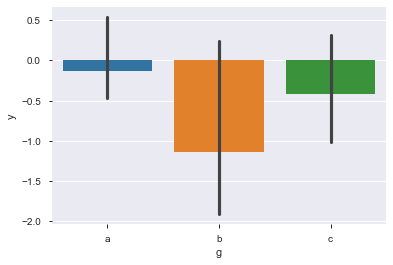

In [27]:
rs = np.random.RandomState(42)
n_total = 10
x = rs.randn(int(n_total / 3), 3)
x_df = pd.DataFrame(x, columns=pd.Series(list("XYZ"), name="big"))
y = pd.Series(rs.randn(n_total), name="y_data")
g = pd.Series(np.repeat(list("abc"), int(n_total / 3)), name="small")
h = pd.Series(np.tile(list("mn"), int(n_total / 2)), name="medium")
u = pd.Series(np.tile(list("jkh"), int(n_total / 3)))
df = pd.DataFrame(dict(y=y, g=g, h=h, u=u))
print(df.describe())
print(df.head())
x_df["W"] = g
sns.barplot(x="g", y="y", data=df)

In [28]:
df_results = pd.DataFrame(x, columns=pd.Series(list("XYZ")))
df_results

,X,Y,Z
0,0.496714,-0.138264,0.647689
1,1.523030,-0.234153,-0.234137
2,1.579213,0.767435,-0.469474
